<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/MLP_AE/MLP_AE_EURCHF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 2.38 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jul 23 14:40:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'EURCHF'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'MLP_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 10.0 MB/s 
     |████████████████████████████████| 170 kB 69.3 MB/s 
     |████████████████████████████████| 138 kB 77.8 MB/s 
     |████████████████████████████████| 133 kB 73.3 MB/s 
     |████████████████████████████████| 97 kB 7.2 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Dense(256, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Dense(128, activation=config.activation))
    # layer 3
    model.add(Dense(64, activation=config.activation))
    # layer 4
    model.add(Dense(32, activation=config.activation))
    # layer 5
    model.add(Flatten())
    # layer 6
    model.add(RepeatVector(window_len))
    # layer 7
    model.add(Dense(32, activation=config.activation))
    # layer 8
    model.add(Dense(64, activation=config.activation))
    # layer 9
    model.add(Dense(128, activation=config.activation))
    # layer 10
    model.add(Flatten())
    # layer 11
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: v8yn3rvz
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_MLP_AE/sweeps/v8yn3rvz


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: 4wjtxmbv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
16/16 [==============================] - 16s 60ms/step - loss: 0.3324 - mean_squared_error: 0.3324 - mean_absolute_error: 0.5270 - val_loss: 0.1506 - val_mean_squared_error: 0.1506 - val_mean_absolute_error: 0.3044
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.1825 - mean_squared_error: 0.1825 - mean_absolute_error: 0.3672 - val_loss: 0.0615 - val_mean_squared_error: 0.0615 - val_mean_absolute_error: 0.1957
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0576 - mean_squared_error: 0.0576 - mean_absolute_error: 0.1746 - val_loss: 0.0643 - val_mean_squared_error: 0.0643 - val_mean_absolute_error: 0.2209
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.1723 - val_loss: 0.0670 - val_mean_squared_error: 0.0670 - val_mean_absolute_error: 0.2263
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0335 - mean_squared_error: 0

wandb: Agent Starting Run: x45vl4qa with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 2s 50ms/step - loss: 0.2042 - mean_squared_error: 0.2042 - mean_absolute_error: 0.3853 - val_loss: 0.1020 - val_mean_squared_error: 0.1020 - val_mean_absolute_error: 0.2779
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0439 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1846 - val_loss: 0.0699 - val_mean_squared_error: 0.0699 - val_mean_absolute_error: 0.2314
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0328 - mean_squared_error: 0.0328 - mean_absolute_error: 0.1607 - val_loss: 0.0501 - val_mean_squared_error: 0.0501 - val_mean_absolute_error: 0.1974
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - mean_absolute_error: 0.1039 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1556
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0092 - mean_squared_erro

wandb: Agent Starting Run: bw8kt0sr with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 3s 50ms/step - loss: 2.1144 - mean_squared_error: 2.1144 - mean_absolute_error: 1.0799 - val_loss: 0.5217 - val_mean_squared_error: 0.5217 - val_mean_absolute_error: 0.6550
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.3499 - mean_squared_error: 0.3499 - mean_absolute_error: 0.4747 - val_loss: 0.2957 - val_mean_squared_error: 0.2957 - val_mean_absolute_error: 0.4793
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.2464 - mean_squared_error: 0.2464 - mean_absolute_error: 0.3909 - val_loss: 0.1734 - val_mean_squared_error: 0.1734 - val_mean_absolute_error: 0.3689
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.1639 - mean_squared_error: 0.1639 - mean_absolute_error: 0.3429 - val_loss: 0.0957 - val_mean_squared_error: 0.0957 - val_mean_absolute_error: 0.2356
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.1282 - mean_squared_

wandb: Agent Starting Run: sgd8at8o with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 3s 84ms/step - loss: 172.7822 - mean_squared_error: 172.7822 - mean_absolute_error: 9.1532 - val_loss: 20.0839 - val_mean_squared_error: 20.0839 - val_mean_absolute_error: 4.2883
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 77.9367 - mean_squared_error: 77.9367 - mean_absolute_error: 7.2394 - val_loss: 14.9552 - val_mean_squared_error: 14.9552 - val_mean_absolute_error: 3.4546
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 53.1012 - mean_squared_error: 53.1012 - mean_absolute_error: 6.7071 - val_loss: 14.2588 - val_mean_squared_error: 14.2588 - val_mean_absolute_error: 3.3390
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 53.8384 - mean_squared_error: 53.8384 - mean_absolute_error: 6.3316 - val_loss: 214.4825 - val_mean_squared_error: 214.4825 - val_mean_absolute_error: 14.4704
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 89.8470 - m

wandb: Agent Starting Run: ubpvll9g with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 3s 27ms/step - loss: 0.1016 - mean_squared_error: 0.1016 - mean_absolute_error: 0.2220 - val_loss: 0.0352 - val_mean_squared_error: 0.0352 - val_mean_absolute_error: 0.1479
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - mean_absolute_error: 0.0876 - val_loss: 0.0298 - val_mean_squared_error: 0.0298 - val_mean_absolute_error: 0.1328
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0759 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1123
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0700 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0808
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0112 - mean_squared_error: 0

wandb: Agent Starting Run: db8jiow8 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 3s 88ms/step - loss: 5.6012 - mean_squared_error: 5.6012 - mean_absolute_error: 1.9910 - val_loss: 5.3983 - val_mean_squared_error: 5.3983 - val_mean_absolute_error: 2.2626
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 2.7358 - mean_squared_error: 2.7358 - mean_absolute_error: 1.4216 - val_loss: 0.0414 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1745
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.1314 - mean_squared_error: 0.1314 - mean_absolute_error: 0.2901 - val_loss: 0.1023 - val_mean_squared_error: 0.1023 - val_mean_absolute_error: 0.2668
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0674 - mean_squared_error: 0.0674 - mean_absolute_error: 0.2047 - val_loss: 0.1035 - val_mean_squared_error: 0.1035 - val_mean_absolute_error: 0.2843
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0605 - mean_squared_error: 0.0605 - 

wandb: Agent Starting Run: 86wifzlv with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 2s 43ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - mean_absolute_error: 0.1036 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0871
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0309 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0801
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0271 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0776
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0274 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0790
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0025 - mean_squared_erro

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2akx16td with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 3s 26ms/step - loss: 0.1001 - mean_squared_error: 0.1001 - mean_absolute_error: 0.2163 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1300
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0784 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1129
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0727 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1119
Epoch 4/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0779 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0913
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0061 - mean_squared_error: 0.

wandb: Agent Starting Run: 488skg27 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 2s 86ms/step - loss: 0.1152 - mean_squared_error: 0.1152 - mean_absolute_error: 0.2890 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1341
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0479 - val_loss: 0.0319 - val_mean_squared_error: 0.0319 - val_mean_absolute_error: 0.1506
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0434 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1291
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0408 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1099
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - 

wandb: Agent Starting Run: wgngwky5 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 3s 51ms/step - loss: 1.4901 - mean_squared_error: 1.4901 - mean_absolute_error: 0.9133 - val_loss: 0.4912 - val_mean_squared_error: 0.4912 - val_mean_absolute_error: 0.6361
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 0.3860 - mean_squared_error: 0.3860 - mean_absolute_error: 0.5175 - val_loss: 0.3244 - val_mean_squared_error: 0.3244 - val_mean_absolute_error: 0.5037
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.2810 - mean_squared_error: 0.2810 - mean_absolute_error: 0.4286 - val_loss: 0.1796 - val_mean_squared_error: 0.1796 - val_mean_absolute_error: 0.3429
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.1216 - mean_squared_error: 0.1216 - mean_absolute_error: 0.2841 - val_loss: 0.0990 - val_mean_squared_error: 0.0990 - val_mean_absolute_error: 0.2390
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 0.1220 - mean_squared_error

wandb: Agent Starting Run: ibowpgqg with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 91ms/step - loss: 0.2807 - mean_squared_error: 0.2807 - mean_absolute_error: 0.4754 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1344
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0647 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1275
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0594 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1148
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0380 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.1009
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0075 - mean_squared_error: 0.0075 -

wandb: Agent Starting Run: ocyquja3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 2s 96ms/step - loss: 0.3572 - mean_squared_error: 0.3572 - mean_absolute_error: 0.5480 - val_loss: 0.1901 - val_mean_squared_error: 0.1901 - val_mean_absolute_error: 0.3536
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.2458 - mean_squared_error: 0.2458 - mean_absolute_error: 0.4433 - val_loss: 0.1200 - val_mean_squared_error: 0.1200 - val_mean_absolute_error: 0.2654
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.1561 - mean_squared_error: 0.1561 - mean_absolute_error: 0.3272 - val_loss: 0.0686 - val_mean_squared_error: 0.0686 - val_mean_absolute_error: 0.2078
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0714 - mean_squared_error: 0.0714 - mean_absolute_error: 0.1904 - val_loss: 0.0640 - val_mean_squared_error: 0.0640 - val_mean_absolute_error: 0.2150
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0434 - mean_squared_error: 0.0

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 63opcfg9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 91ms/step - loss: 0.7046 - mean_squared_error: 0.7046 - mean_absolute_error: 0.6171 - val_loss: 0.0838 - val_mean_squared_error: 0.0838 - val_mean_absolute_error: 0.2532
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0440 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1680 - val_loss: 0.0767 - val_mean_squared_error: 0.0767 - val_mean_absolute_error: 0.2408
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - mean_absolute_error: 0.1202 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1444
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0630 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1333
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0082 - mean_squared_error: 0.0

wandb: Agent Starting Run: g9iq07ry with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 2s 26ms/step - loss: 0.2911 - mean_squared_error: 0.2911 - mean_absolute_error: 0.4850 - val_loss: 0.0623 - val_mean_squared_error: 0.0623 - val_mean_absolute_error: 0.1981
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0570 - mean_squared_error: 0.0570 - mean_absolute_error: 0.1866 - val_loss: 0.0705 - val_mean_squared_error: 0.0705 - val_mean_absolute_error: 0.2322
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0374 - mean_squared_error: 0.0374 - mean_absolute_error: 0.1725 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.2186
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.1598 - val_loss: 0.0604 - val_mean_squared_error: 0.0604 - val_mean_absolute_error: 0.2157
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0298 - mean_squared_erro

wandb: Agent Starting Run: etgddsac with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 2s 95ms/step - loss: 0.3315 - mean_squared_error: 0.3315 - mean_absolute_error: 0.5306 - val_loss: 0.2163 - val_mean_squared_error: 0.2163 - val_mean_absolute_error: 0.3870
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.3001 - mean_squared_error: 0.3001 - mean_absolute_error: 0.4973 - val_loss: 0.1745 - val_mean_squared_error: 0.1745 - val_mean_absolute_error: 0.3329
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.2456 - mean_squared_error: 0.2456 - mean_absolute_error: 0.4405 - val_loss: 0.1292 - val_mean_squared_error: 0.1292 - val_mean_absolute_error: 0.2761
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.1747 - mean_squared_error: 0.1747 - mean_absolute_error: 0.3536 - val_loss: 0.0903 - val_mean_squared_error: 0.0903 - val_mean_absolute_error: 0.2296
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.1200 - mean_squared_error: 0.1

wandb: Agent Starting Run: n5jqlfoa with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 90ms/step - loss: 2.2528 - mean_squared_error: 2.2528 - mean_absolute_error: 1.1780 - val_loss: 0.5099 - val_mean_squared_error: 0.5099 - val_mean_absolute_error: 0.6834
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.2169 - mean_squared_error: 0.2169 - mean_absolute_error: 0.3824 - val_loss: 0.5183 - val_mean_squared_error: 0.5183 - val_mean_absolute_error: 0.6669
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.4028 - mean_squared_error: 0.4028 - mean_absolute_error: 0.5644 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1224
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0302 - mean_squared_error: 0.0302 - mean_absolute_error: 0.1455 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1151
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0140 - mean_squared_error: 0.0

wandb: Agent Starting Run: 6tav6hwe with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 3s 86ms/step - loss: 1.6069 - mean_squared_error: 1.6069 - mean_absolute_error: 1.0996 - val_loss: 0.3806 - val_mean_squared_error: 0.3806 - val_mean_absolute_error: 0.5520
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.4460 - mean_squared_error: 0.4460 - mean_absolute_error: 0.5952 - val_loss: 0.0307 - val_mean_squared_error: 0.0307 - val_mean_absolute_error: 0.1480
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.1861 - mean_squared_error: 0.1861 - mean_absolute_error: 0.3314 - val_loss: 0.0950 - val_mean_squared_error: 0.0950 - val_mean_absolute_error: 0.2503
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.2696 - mean_squared_error: 0.2696 - mean_absolute_error: 0.3662 - val_loss: 0.4498 - val_mean_squared_error: 0.4498 - val_mean_absolute_error: 0.6164
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.2985 - mean_squared_error: 0.2

wandb: Agent Starting Run: bdtjfqoi with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 2s 46ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan 

wandb: Agent Starting Run: 05263cao with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 2s 45ms/step - loss: 0.2335 - mean_squared_error: 0.2335 - mean_absolute_error: 0.4101 - val_loss: 0.1156 - val_mean_squared_error: 0.1156 - val_mean_absolute_error: 0.2966
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0505 - mean_squared_error: 0.0505 - mean_absolute_error: 0.2017 - val_loss: 0.0701 - val_mean_squared_error: 0.0701 - val_mean_absolute_error: 0.2282
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0410 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1773 - val_loss: 0.0652 - val_mean_squared_error: 0.0652 - val_mean_absolute_error: 0.2230
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0290 - mean_squared_error: 0.0290 - mean_absolute_error: 0.1486 - val_loss: 0.0499 - val_mean_squared_error: 0.0499 - val_mean_absolute_error: 0.1968
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0147 - mean_squared_error: 0

wandb: Agent Starting Run: kanyj3c0 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 2s 26ms/step - loss: 1.4696 - mean_squared_error: 1.4696 - mean_absolute_error: 0.7305 - val_loss: 0.0684 - val_mean_squared_error: 0.0684 - val_mean_absolute_error: 0.2097
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.1270 - mean_squared_error: 0.1270 - mean_absolute_error: 0.2335 - val_loss: 0.0467 - val_mean_squared_error: 0.0467 - val_mean_absolute_error: 0.1623
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 0.1267 - mean_squared_error: 0.1267 - mean_absolute_error: 0.2319 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1098
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0755 - mean_squared_error: 0.0755 - mean_absolute_error: 0.1846 - val_loss: 0.0311 - val_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.1484
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0228 - mean_squared_err

wandb: Agent Starting Run: 2v0anluw with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 47ms/step - loss: 58.0234 - mean_squared_error: 58.0234 - mean_absolute_error: 3.5386 - val_loss: 0.0222 - val_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.1202
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.3816 - mean_squared_error: 0.3816 - mean_absolute_error: 0.3224 - val_loss: 0.0345 - val_mean_squared_error: 0.0345 - val_mean_absolute_error: 0.1525
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0926 - mean_squared_error: 0.0926 - mean_absolute_error: 0.1498 - val_loss: 2.5502 - val_mean_squared_error: 2.5502 - val_mean_absolute_error: 1.5568
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 1.2739 - mean_squared_error: 1.2739 - mean_absolute_error: 0.8561 - val_loss: 0.0480 - val_mean_squared_error: 0.0480 - val_mean_absolute_error: 0.1791
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.3070 - mean_squared_error

wandb: Agent Starting Run: 1sv7dyy7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 3s 27ms/step - loss: 19938.9644 - mean_squared_error: 19938.9644 - mean_absolute_error: 68.9831 - val_loss: 1.3510 - val_mean_squared_error: 1.3510 - val_mean_absolute_error: 1.0564
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 165.0129 - mean_squared_error: 165.0129 - mean_absolute_error: 8.8561 - val_loss: 338.4901 - val_mean_squared_error: 338.4901 - val_mean_absolute_error: 18.3326
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 71.6516 - mean_squared_error: 71.6516 - mean_absolute_error: 4.9855 - val_loss: 19.2433 - val_mean_squared_error: 19.2433 - val_mean_absolute_error: 4.3787
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 10.1434 - mean_squared_error: 10.1434 - mean_absolute_error: 1.8857 - val_loss: 0.0796 - val_mean_squared_error: 0.0796 - val_mean_absolute_error: 0.2407
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 4

wandb: Agent Starting Run: 89jed04n with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 2s 49ms/step - loss: 0.3028 - mean_squared_error: 0.3028 - mean_absolute_error: 0.4986 - val_loss: 0.0971 - val_mean_squared_error: 0.0971 - val_mean_absolute_error: 0.2376
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.1023 - mean_squared_error: 0.1023 - mean_absolute_error: 0.2453 - val_loss: 0.0869 - val_mean_squared_error: 0.0869 - val_mean_absolute_error: 0.2574
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1965 - val_loss: 0.0676 - val_mean_squared_error: 0.0676 - val_mean_absolute_error: 0.2266
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0379 - mean_squared_error: 0.0379 - mean_absolute_error: 0.1694 - val_loss: 0.0613 - val_mean_squared_error: 0.0613 - val_mean_absolute_error: 0.2152
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0352 - mean_squared_er

wandb: Agent Starting Run: v73hufjp with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 97ms/step - loss: 0.2381 - mean_squared_error: 0.2381 - mean_absolute_error: 0.3852 - val_loss: 0.0683 - val_mean_squared_error: 0.0683 - val_mean_absolute_error: 0.2002
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0647 - mean_squared_error: 0.0647 - mean_absolute_error: 0.2012 - val_loss: 0.0496 - val_mean_squared_error: 0.0496 - val_mean_absolute_error: 0.1955
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0245 - mean_squared_error: 0.0245 - mean_absolute_error: 0.1276 - val_loss: 0.0420 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1665
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0775 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1397
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0066 - mean_squared_error: 0.0

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s90u7j16 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 3s 48ms/step - loss: 1.8408 - mean_squared_error: 1.8408 - mean_absolute_error: 0.9907 - val_loss: 0.2007 - val_mean_squared_error: 0.2007 - val_mean_absolute_error: 0.4251
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.4316 - mean_squared_error: 0.4316 - mean_absolute_error: 0.5650 - val_loss: 0.0960 - val_mean_squared_error: 0.0960 - val_mean_absolute_error: 0.2587
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 0.2866 - mean_squared_error: 0.2866 - mean_absolute_error: 0.4259 - val_loss: 0.1034 - val_mean_squared_error: 0.1034 - val_mean_absolute_error: 0.2469
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.1957 - mean_squared_error: 0.1957 - mean_absolute_error: 0.3884 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1314
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0768 - mean_squared_

wandb: Agent Starting Run: lbq9pya0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 3s 104ms/step - loss: 0.2606 - mean_squared_error: 0.2606 - mean_absolute_error: 0.4510 - val_loss: 0.0422 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1714
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0724 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - val_mean_absolute_error: 0.1382
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0715 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1273
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0513 - val_loss: 0.0222 - val_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.1195
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0077 - mean_squared_error: 0.

wandb: Agent Starting Run: izcbhuta with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 2s 93ms/step - loss: 0.0704 - mean_squared_error: 0.0704 - mean_absolute_error: 0.2263 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1218
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0533 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1137
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0340 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1094
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0309 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0932
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046 -

wandb: Agent Starting Run: zswhfeb5 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 3s 86ms/step - loss: 1.0100 - mean_squared_error: 1.0100 - mean_absolute_error: 0.7870 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.1466
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.1219 - mean_squared_error: 0.1219 - mean_absolute_error: 0.2482 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1383
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0714 - mean_squared_error: 0.0714 - mean_absolute_error: 0.2078 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1284
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0751 - mean_squared_error: 0.0751 - mean_absolute_error: 0.2132 - val_loss: 0.0736 - val_mean_squared_error: 0.0736 - val_mean_absolute_error: 0.2229
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0704 - mean_squared_error: 0.0

wandb: Agent Starting Run: hrlphrxd with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 4s 33ms/step - loss: 0.1502 - mean_squared_error: 0.1502 - mean_absolute_error: 0.3055 - val_loss: 0.0573 - val_mean_squared_error: 0.0573 - val_mean_absolute_error: 0.1962
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0521 - mean_squared_error: 0.0521 - mean_absolute_error: 0.1736 - val_loss: 0.0376 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1675
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0687 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1355
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0737 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.1257
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0081 - mean_squared_

wandb: Agent Starting Run: agu9xns3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 2s 89ms/step - loss: 41.0621 - mean_squared_error: 41.0621 - mean_absolute_error: 3.9680 - val_loss: 0.0425 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1760
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0294 - mean_squared_error: 0.0294 - mean_absolute_error: 0.1473 - val_loss: 0.0298 - val_mean_squared_error: 0.0298 - val_mean_absolute_error: 0.1476
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0702 - mean_squared_error: 0.0702 - mean_absolute_error: 0.1793 - val_loss: 2.4525 - val_mean_squared_error: 2.4525 - val_mean_absolute_error: 1.5405
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 2.7609 - mean_squared_error: 2.7609 - mean_absolute_error: 1.5222 - val_loss: 0.0546 - val_mean_squared_error: 0.0546 - val_mean_absolute_error: 0.1702
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0835 - mean_squared_error: 0

wandb: Agent Starting Run: i4b3vkx9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 2s 45ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error:

wandb: Agent Starting Run: x6bctxqu with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 3s 30ms/step - loss: 2.3516 - mean_squared_error: 2.3516 - mean_absolute_error: 0.8371 - val_loss: 0.0479 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1813
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0478 - mean_squared_error: 0.0478 - mean_absolute_error: 0.1691 - val_loss: 0.0772 - val_mean_squared_error: 0.0772 - val_mean_absolute_error: 0.2392
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0599 - mean_squared_error: 0.0599 - mean_absolute_error: 0.1787 - val_loss: 0.0717 - val_mean_squared_error: 0.0717 - val_mean_absolute_error: 0.2315
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0239 - mean_squared_error: 0.0239 - mean_absolute_error: 0.1152 - val_loss: 0.0527 - val_mean_squared_error: 0.0527 - val_mean_absolute_error: 0.1900
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0149 - mean_squared_er

wandb: Agent Starting Run: iohgg7y2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 2s 26ms/step - loss: 0.2934 - mean_squared_error: 0.2934 - mean_absolute_error: 0.4901 - val_loss: 0.0854 - val_mean_squared_error: 0.0854 - val_mean_absolute_error: 0.2245
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0789 - mean_squared_error: 0.0789 - mean_absolute_error: 0.2068 - val_loss: 0.0789 - val_mean_squared_error: 0.0789 - val_mean_absolute_error: 0.2439
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0448 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1918 - val_loss: 0.0728 - val_mean_squared_error: 0.0728 - val_mean_absolute_error: 0.2339
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0402 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1753 - val_loss: 0.0713 - val_mean_squared_error: 0.0713 - val_mean_absolute_error: 0.2319
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0400 - mean_squared_error: 0.

wandb: Agent Starting Run: iw7jeq5n with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 3s 168ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan 

wandb: Agent Starting Run: sq3760m6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 3s 48ms/step - loss: 0.1646 - mean_squared_error: 0.1646 - mean_absolute_error: 0.3155 - val_loss: 0.0311 - val_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.1457
Epoch 2/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0760 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1201
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0479 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1076
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0506 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1098
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0059 - mean_squared_

wandb: Agent Starting Run: z5ae1xsx with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 2s 85ms/step - loss: 0.3083 - mean_squared_error: 0.3083 - mean_absolute_error: 0.4557 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1126
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0507 - val_loss: 0.0395 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1513
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0505 - val_loss: 0.0298 - val_mean_squared_error: 0.0298 - val_mean_absolute_error: 0.1275
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0508 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1205
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0094 - mean_squared_error: 0.0

wandb: Agent Starting Run: 221r81is with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 47ms/step - loss: 0.5596 - mean_squared_error: 0.5596 - mean_absolute_error: 0.6423 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1030
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0303 - mean_squared_error: 0.0303 - mean_absolute_error: 0.1397 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.1171
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0712 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0807
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0340 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0715
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0024 - mean_squared_

wandb: Processing terminal ouput (stdout)...
wandb: Done.


wandb: Agent Starting Run: 1zyuyiht with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 2s 86ms/step - loss: 0.4780 - mean_squared_error: 0.4780 - mean_absolute_error: 0.5455 - val_loss: 0.0326 - val_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.1503
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0470 - val_loss: 0.0314 - val_mean_squared_error: 0.0314 - val_mean_absolute_error: 0.1425
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0437 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1242
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0432 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1127
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038 -

wandb: Agent Starting Run: 182r8hh5 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 64,
    'learning_rate': 0.0005,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Dense(256, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Dense(128, activation=best_config['activation']))
# layer 3
model.add(Dense(64, activation=best_config['activation']))
# layer 4
model.add(Dense(32, activation=best_config['activation']))
# layer 5
model.add(Flatten())
# layer 6
model.add(RepeatVector(window_len))
# layer 7
model.add(Dense(32, activation=best_config['activation']))
# layer 8
model.add(Dense(64, activation=best_config['activation']))
# layer 9
model.add(Dense(128, activation=best_config['activation']))
# layer 10
model.add(Flatten())
# layer 11
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  88769


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 256)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 30, 128)           32896     
_________________________________________________________________
dense_2 (Dense)              (None, 30, 64)            8256      
_________________________________________________________________
dense_3 (Dense)              (None, 30, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 960)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 30, 32)            3

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
20/20 [==============================] - 2s 6ms/step - loss: 0.7157
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0252
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0039
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0034
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 9.0079e-04
Epoch 8/100
20/20 [==============================] - 0s 5ms/step - loss: 9.5433e-04
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 10/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 11/100
20/20 [==============================] - 0s 5ms/step - loss: 7.9066e-04
Epoch 12/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 13/100
20/20 [=====

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

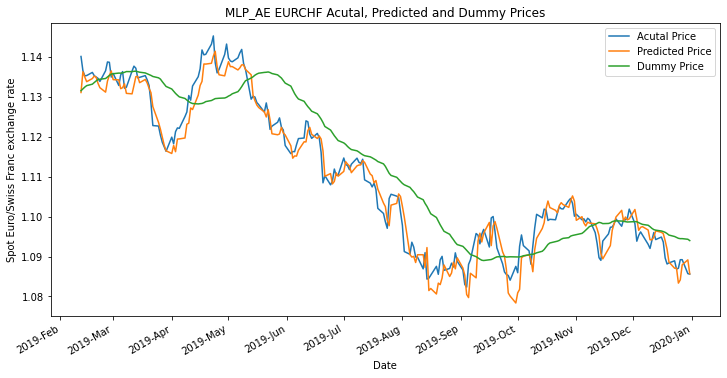

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

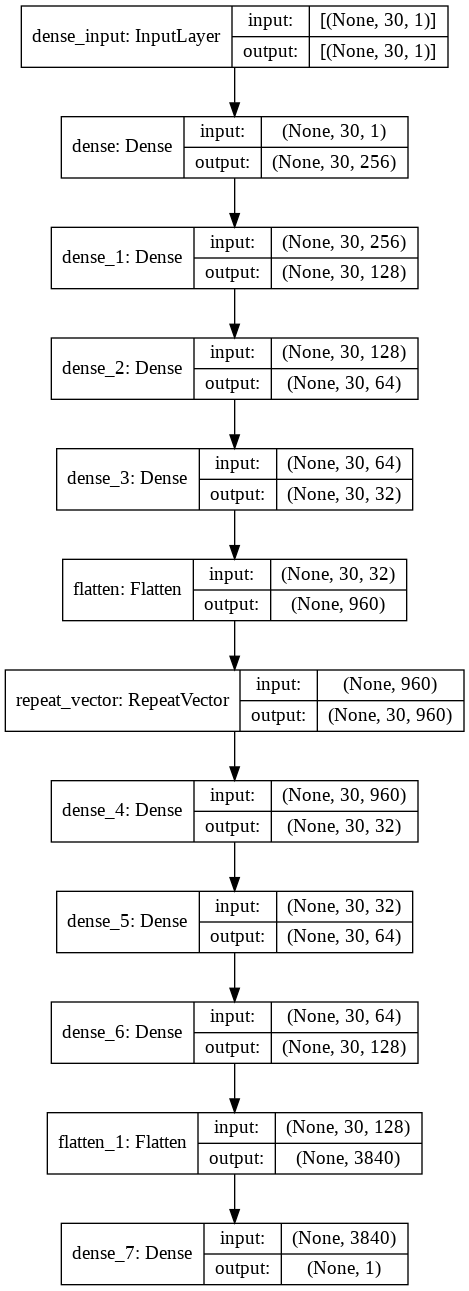

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0029967570587818002
RMSE:  0.0547426438782582
MAE:  0.042515564839814786
Dummy MSE:  0.01696823190684472
Dummy RMSE:  0.13026216606077423
Dummy MAE:  0.10864031818078547


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/MLP_AE_EURCHF/assets
